# LangGraph

## 사전 준비 : 가상 환경 구축, 패키지 설치

In [1]:
#1

!pip uninstall -y google-generativeai
!pip install langchain==0.3.20 langchain_core==0.3.49 langchain_google_genai==2.1.1 httpx==0.28.1 requests==2.32.3 langgraph==0.3.8

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
INFO: pip is looking at multiple versions of langchain-text-splitters to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14

## 대화 이력을 유지하는 방법

In [2]:
#2

import os
import uuid

#환경 변수와 패키지 준비
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
#os.environ["GOOGLE_API_KEY"] = "***"

import operator
from typing import TypedDict, Annotated

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph



In [3]:
#3

# gemini 모델 정의
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0
)

# message 작성
message = [
    SystemMessage(content= "당신은 한국어를 말하는 우수한 어시스턴트입니다. 회답에는 반드시 한국어로 대답해 주세요. 또 생각하는 과정도 출력해 주세요."),
    MessagesPlaceholder("messages"),
]

# message 프롬프트 작성
prompt = ChatPromptTemplate.from_messages(message)

#chain 정의
chain = prompt | model

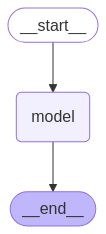

In [4]:
#4

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

def create_langgraph(chain):

    def call_llm(state: GraphState):
        response = chain.invoke({"messages":state["messages"]})
        return {"messages": [response]}

    workflow = StateGraph(state_schema=GraphState)
    workflow.add_node("model", call_llm)

    workflow.add_edge(START, "model")
    workflow.add_edge("model", END)

    memory = MemorySaver()
    graph = workflow.compile(checkpointer=memory)
    return graph

graph = create_langgraph(chain)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
#5

while True:
    query = input("질문을 입력하세요: ")

    if query.lower() in ["exit", "quit"]:
        print("종료합니다.")
        break

    print("################# 질문 #################")
    print("질문:", query)

    input_query = [HumanMessage(
            [
                {
                    "type": "text",
                    "text": f"{query}"
                },
            ]
        )]

    response = graph.invoke({"messages": input_query} ,config={"configurable": {"thread_id": uuid.uuid4()}})

    print("################# 응답 #################")
    print("AI 응답",response["messages"][-1].content)




질문을 입력하세요: 나는 미물입니다.
################# 질문 #################
질문: 나는 미물입니다.
################# 응답 #################
AI 응답 알겠습니다. 당신이 자신을 "미물"이라고 표현하셨군요. 이 단어는 일반적으로 작고 하찮은 존재, 또는 중요하지 않다고 여겨지는 존재를 가리킬 때 사용됩니다. 

당신이 왜 자신을 미물이라고 생각하는지, 그리고 어떤 맥락에서 그런 표현을 사용했는지 조금 더 알려주시면 더 적절한 답변을 드릴 수 있을 것 같습니다. 예를 들어, 다음과 같은 질문에 답해주시면 도움이 될 것입니다.

*   **어떤 상황에서 자신을 미물이라고 느끼셨나요?**
*   **미물이라는 단어가 당신에게 어떤 의미를 가지나요?**
*   **혹시 어떤 감정을 표현하고 싶으신 건가요? (예: 무력감, 겸손함 등)**

이러한 정보를 바탕으로 당신의 생각과 감정을 더 잘 이해하고, 필요한 도움이나 조언을 제공할 수 있도록 노력하겠습니다.
질문을 입력하세요: 나의 직업은 개발자인데, 개발자의 비전은 어떻습니까?
################# 질문 #################
질문: 나의 직업은 개발자인데, 개발자의 비전은 어떻습니까?
################# 응답 #################
AI 응답 ## 개발자의 비전에 대한 생각 과정

개발자의 비전은 매우 광범위하고 다각적입니다. 기술 발전 속도가 매우 빠르기 때문에, 미래를 예측하기는 어렵지만, 현재 트렌드와 기술 발전 방향을 고려하여 다음과 같은 요소들을 중심으로 생각해 볼 수 있습니다.

1.  **기술 트렌드 분석:** 현재 어떤 기술들이 부상하고 있는지, 그리고 어떤 기술들이 쇠퇴하고 있는지 파악합니다. 예를 들어, 인공지능, 머신러닝, 클라우드 컴퓨팅, 블록체인, 양자 컴퓨팅 등이 중요한 기술 트렌드입니다.
2.  **사회적 요구 분석:** 사회가 어떤 문제들을 겪고 있고, 어떤 기술들이 이러한 문제들을 해